In [1]:
from google.colab import drive
drive.mount('/content/drive')

#loading the trained  model

from keras.models import load_model 
model = load_model('/content/drive/MyDrive/smallmodel_fold2_trail3.h5')

Mounted at /content/drive


In [2]:
#architecture of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 256)     19456     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 256)       1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       1638656   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 512)         3

In [3]:
#model configuration
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 1e-07,
 'name': 'Adam'}

In [4]:
#this function takes the each patch in WSI then predicts the probability score
def pred_each_patch(path,name):
    y = image.load_img(os.path.join(path, name))
    img = image.img_to_array(y)
    y = np.expand_dims(img, axis = 0)
    # y = preprocess_input(y)
    y /= 255
    y_pred = model.predict(y)
    return y_pred
        
def avg(predlist):
    average = sum(predlist)/len(predlist)
    return average

def extract_index_one_frmpred(prediction_list):               
    ypred = np.stack(prediction_list)#we are vertically stacking the predictions
    ypred = np.reshape(ypred, [len(prediction_list),2])#reshaping to 100,2 - np array
    for each in ypred:
    #after reshaping the predictions as we wanted, we are taking the index '1' to compute whole slide level AUC-ROC
        val = each[1]
        pred_prob_list.append(val)#appending all the values into a list - to compute average values of single WSI and maximum of single WSI.
        
    return pred_prob_list

def y_labels(path):
  if "Epithelioid" in path:
    y_test_labels.append(0.0)
  elif "Nonepithelioid" in path:
    y_test_labels.append(1.0) 
  return



In [5]:
!unzip drive/My\ Drive/2000_fold2_new.zip
!unzip drive/My\ Drive/Test_2000_new.zip

Streaming output truncated to the last 5000 lines.
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/91361-31932.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/126841-58542.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/130389-62090.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/33706-37254.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/27497-54994.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/104666-53220.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/116197-52333.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998

In [6]:
#related modules 
import keras
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,auc
from sklearn.metrics import average_precision_score
import tensorflow as tf
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import os
import glob
import pandas as pd
from fnmatch import fnmatch

In [7]:
#reading the dataset
train_path = "/content/2000_fold2_new/Train"
val_path = "/content/2000_fold2_new/Validation"
test_path ="/content/Test_2000_new"

batch_size = 32

file_pattern = "*.jpg"
folder_pattern = "*TCGA-*"


# loss_function ='categorical_crossentropy'
# epoch = 50

# #reading train and validation data
# data_generator = ImageDataGenerator(rescale = 1./255)
# #loop and iterating through train images
# train_data_generator = data_generator.flow_from_directory(train_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle =True)
# #iterating through images of validation set
# val_data_generator = data_generator.flow_from_directory(val_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle = True)
# # classes = train_data_generator.classes
# class_weights_list = class_weight.compute_class_weight('balanced',np.unique(train_data_generator.classes),train_data_generator.classes)
# weights = dict(zip(np.unique(train_data_generator.classes),class_weights_list))
# print("weights ratio to make the dataset balanced: ",weights)

# print("class Indices of train generator :",train_data_generator.class_indices)
# print("class Indices of validation generator :",val_data_generator.class_indices)

In [8]:
AVG_LIST_PREDICTIONS_VAL = []
MAX_LIST_PREDICTIONS_VAL = []
y_val_labels= []
print("Prediction on validation data using aggregation method")
for path, subdirs, files in os.walk(val_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        if "Epithelioid" in path:
          y_val_labels.append(0.0)
        elif "Nonepithelioid" in path:
          y_val_labels.append(1.0) 

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS_VAL.append(avg(predictions))
        MAX_LIST_PREDICTIONS_VAL.append(max(predictions))




Prediction on validation data using aggregation method


AUC - ROC on validation data average prediction scores: 0.7374999999999999
-----------------------------------------------------


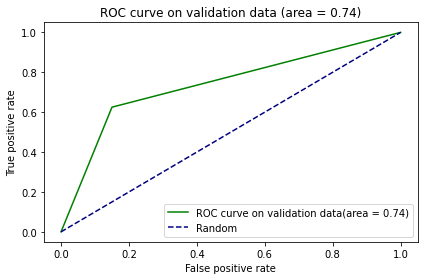

AUC - ROC on validation data maximum prediction scores: 0.5
-----------------------------------------------------


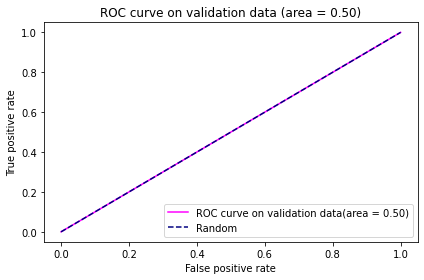

In [34]:
false_pr_avg,true_pr_avg,threshold = roc_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on validation data average prediction scores:",roc_auc_avg)
print("-----------------------------------------------------")
plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()


false_pr_max,true_pr_max,threshold = roc_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
roc_auc_max = auc(false_pr_max,true_pr_max)
print("AUC - ROC on validation data maximum prediction scores:",roc_auc_max)
print("-----------------------------------------------------")
plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Presicion - Recall auc on validation data average score predictions: 0.6785714285714286
-----------------------------------------------------


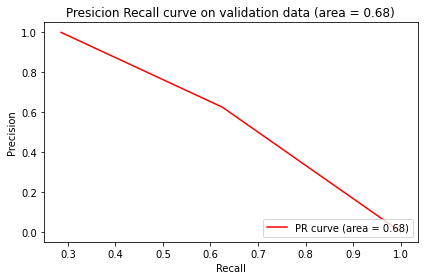

Presicion - Recall auc on validation data maximum score predictions: 0.6428571428571428
-----------------------------------------------------


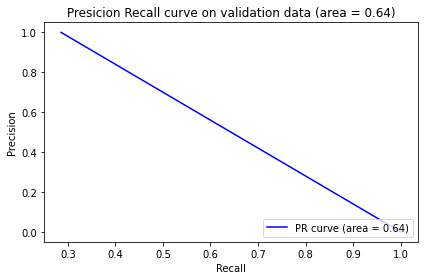

In [35]:
#presicion - recall curve
precision, recall, threshold = precision_recall_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data average score predictions:",auc(recall,precision))
 
print("-----------------------------------------------------")
plt.plot(precision, recall,color='red',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall,precision)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

precision_max, recall_max, threshold = precision_recall_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data maximum score predictions:",auc(recall_max,precision_max))
print("-----------------------------------------------------")
plt.plot(precision_max, recall_max,color='blue',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [36]:
import sklearn
#classification report on average prediction values
AVG_LIST_PREDICTIONS_VAL = [round(x) for x in AVG_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,AVG_LIST_PREDICTIONS_VAL))

print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")

#classification report on maximum prediction values
MAX_LIST_PREDICTIONS_VAL = [round(x) for x in MAX_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,MAX_LIST_PREDICTIONS_VAL))

CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        20
         1.0       0.62      0.62      0.62         8

    accuracy                           0.79        28
   macro avg       0.74      0.74      0.74        28
weighted avg       0.79      0.79      0.79        28

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.29      1.00      0.44         8

    accuracy                           0.29        28
   macro avg       0.14      0.50      0.22        28
weighted avg       0.08      0.29      0.13        28



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**EVALUATION ON TESTSET**

In [12]:
AVG_LIST_PREDICTIONS = []
MAX_LIST_PREDICTIONS = []
y_test_labels= []
print("Prediction on test using aggregation method")
for path, subdirs, files in os.walk(test_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        y_labels(path)

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        AVG_LIST_PREDICTIONS.append(avg(predictions))
        MAX_LIST_PREDICTIONS.append(max(predictions))

Prediction on test using aggregation method


In [25]:
false_pr_avg,true_pr_avg,threshold = roc_curve(y_test_labels,AVG_LIST_PREDICTIONS)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on Test data average prediction scores:",roc_auc_avg)
print("-----------------------------------------------------")

AUC - ROC on Test data average prediction scores: 0.6499999999999999
-----------------------------------------------------


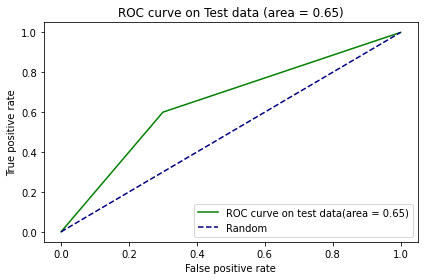

In [26]:
plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [27]:
false_pr_max,true_pr_max,threshold = roc_curve(y_test_labels,MAX_LIST_PREDICTIONS)
roc_auc_max = auc(false_pr_max,true_pr_max)
print("AUC - ROC on Test data maximum prediction scores:",roc_auc_max)
print("-----------------------------------------------------")

AUC - ROC on Test data maximum prediction scores: 0.5
-----------------------------------------------------


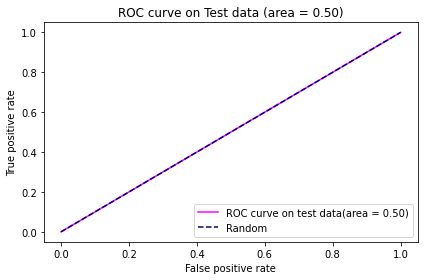

In [28]:
plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [29]:
precision, recall, threshold = precision_recall_curve(y_test_labels,AVG_LIST_PREDICTIONS)
print("Presicion - Recall auc on test data average score predictions:",auc(recall,precision))
print("-----------------------------------------------------")

Presicion - Recall auc on test data average score predictions: 0.5066666666666666
-----------------------------------------------------


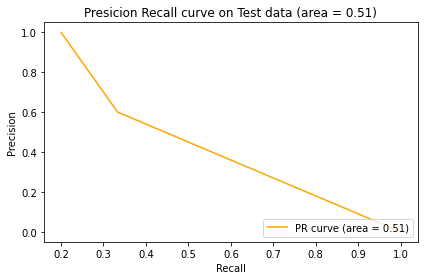

In [30]:
plt.plot(precision, recall,color='orange',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall,precision)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [31]:
precision_max, recall_max, threshold = precision_recall_curve(y_test_labels,MAX_LIST_PREDICTIONS)
print("Presicion - Recall auc on test data maximum score predictions:",auc(recall_max,precision_max))
print("-----------------------------------------------------")

Presicion - Recall auc on test data maximum score predictions: 0.6
-----------------------------------------------------


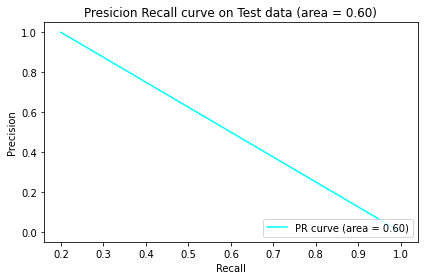

In [32]:
plt.plot(precision_max, recall_max,color='cyan',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [37]:
from sklearn.metrics import classification_report
AVG_LIST_PREDICTIONS = [round(x) for x in AVG_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT")
print(classification_report(y_test_labels,AVG_LIST_PREDICTIONS))
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
MAX_LIST_PREDICTIONS = [round(x) for x in MAX_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT for MAX VALUE PREDICTIONS")
print(classification_report(y_test_labels,MAX_LIST_PREDICTIONS))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.88      0.70      0.78        20
         1.0       0.33      0.60      0.43         5

    accuracy                           0.68        25
   macro avg       0.60      0.65      0.60        25
weighted avg       0.77      0.68      0.71        25

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
CLASSIFICATION REPORT for MAX VALUE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.20      1.00      0.33         5

    accuracy                           0.20        25
   macro avg       0.10      0.50      0.17        25
weighted avg       0.04      0.20      0.07        25



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SAVING THE PREDICTIONS**

In [22]:
#creating a datframe to save predictions with actuals
df = pd.DataFrame()
df['Average'] = AVG_LIST_PREDICTIONS
df['Maximum'] = MAX_LIST_PREDICTIONS
df['Actual labels'] = y_test_labels
#saving into csv file for futher use
df.to_csv('savingpred_fold2_test.csv',index = False,header = True)
!cp savingpred_fold2_test.csv "drive/My Drive/"

In [23]:
#creating a datframe to save predictions with actuals
df_val = pd.DataFrame()
df_val['Average'] = AVG_LIST_PREDICTIONS_VAL
df_val['Maximum'] = MAX_LIST_PREDICTIONS_VAL
df_val['Actual labels'] = y_val_labels
#saving into csv file for futher use
df_val.to_csv('savingpred_fold2_val.csv',index = False,header = True)
!cp savingpred_fold2_val.csv "drive/My Drive/"

In [24]:
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,auc


df_1 = pd.read_csv("/content/drive/MyDrive/smallmodel_test_fold2_trail3.csv")
average_fold1 = df_1['Average'].tolist()
actual_labelsfold1 = df_1['Actual labels'].tolist()
maximum_fold1 = df_1['Maximum'].tolist()

false_pr_avg,true_pr_avg,threshold = roc_curve(actual_labelsfold1,average_fold1)
roc_auc_avg1 = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on Test data average prediction scores:",roc_auc_avg1)


false_pr_avg,true_pr_avg,threshold = roc_curve(actual_labelsfold1,maximum_fold1)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on Test data maximum prediction scores:",roc_auc_avg)

AUC - ROC on Test data average prediction scores: 0.6499999999999999
AUC - ROC on Test data maximum prediction scores: 0.5
